# ZCB using credit spread

In [3]:
import numpy as np

def cs(PD, Rec, rf, T, N=100):
    return -(1/T)*np.log((1-PD)*(1-Rec)+Rec)
cs(0.045, 0.4, 0.018, 3)

In [15]:
def price_ZCB_creditspread(PD, Rec, rf, T):
    def cs(PD, Rec, rf, T, N=100):
        return -(1/T)*np.log((1-PD)*(1-Rec)+Rec)
    return np.exp((rf+cs(PD, Rec, rf, T))*-1*T)
#V_D = np.exp((rf+cs(PD, R, rf, T))*-1*3)
#V_D

In [17]:
price_ZCB_creditspread(PD=0.045, Rec=0.4, rf=0.018, T=3)

0.9218514396262497

# Pricing risk coupon bonds

In [2]:
import math

In [8]:
def price_risky_coupon_bond(term_structure, c, m, Rec, N=100):
    """
    term stucture: nest dict of {dict: terms, keys: spot_rate, survival_prob}
    """
    def discount(spot_rate, spot=True, t=1):
        """
        or discount factor: spot_rate=False for reverse
        """
        if spot==True:
            return math.exp(-spot_rate*t)
        else: return -np.log(spot_rate)/t
    def sum1(term_structure):
        sum = 0
        for x in term_structure:
            sum += discount(term_structure[x]['spot_rate'], t=x)*term_structure[x]['survival_prob']
        return sum

    def sum2(term_structure):
        sum = 0
        for i,x in enumerate(term_structure):
            if i == 0:
                sum += discount(term_structure[x]['spot_rate'], t=x)*\
                (1-term_structure[x]['survival_prob'])
            else:
                sum += discount(term_structure[x]['spot_rate'], t=x)*\
                (term_structure[list(term_structure)[i-1]]['survival_prob']-\
                 term_structure[x]['survival_prob'])
        return sum
    return (c/m)*N*sum1(term_structure) \
    + term_structure[list(term_structure)[-1]]['survival_prob']\
    * discount(term_structure[list(term_structure)[-1]]['spot_rate'],t=list(term_structure)[-1])*N\
    + N*Rec*sum2(term_structure)

In [9]:
#eg 1
term_structure = {
    0.5: {'spot_rate': 0.025, 'survival_prob': 0.93},
    1: {'spot_rate': 0.03, 'survival_prob': 0.91}
}
price_risky_coupon_bond(term_structure, c=0.08, m=2, Rec=0.45)

99.50102576461744

In [10]:
#eg 2
term_structure = {
    0.5: {'spot_rate': 0.03, 'survival_prob': 0.98},
    1: {'spot_rate': 0.035, 'survival_prob': 0.94}
}
price_risky_coupon_bond(term_structure, c=0.06, m=2, Rec=0.4, N=1)

0.9871920372218514

# Bootstapping implied survival probability 

In [119]:
#eg1
bonds = {
    1: {'c':0.04, 'p':0.97, 'd':0.99},
    2: {'c':0.05, 'p':0.96, 'd':0.98}
}
N = 1
Rec = 0.4
m =1

Q = ((bonds[1]['p']/N)-Rec*bonds[1]['d'])/(bonds[1]['d']*(1+bonds[1]['c']/m-Rec))
Q

0.9059343434343433

In [57]:
def discount(spot_rate, spot=True, t=1):
    """
    or discount factor: spot_rate=False for reverse
    """
    if spot==True:
        return math.exp(-spot_rate*t)
    else: return -np.log(spot_rate)/t
    
bonds = {
    0.5: {'c':0.04, 'p':0.95, 'd':discount(0.02, t=0.5)},
    1: {'c':0.05, 'p':0.96, 'd':discount(0.03, t=1)}
}
N = 1
Rec = 0.4
m = 2

In [67]:
bonds[0.5]['Q'] = ((bonds[0.5]['p']/bonds[0.5]['d'])-Rec)/(1+bonds[0.5]['c']/m-Rec)
bonds

{0.5: {'c': 0.04, 'p': 0.95, 'd': 0.9900498337491681, 'Q': 0.9024962237579992},
 1: {'c': 0.05, 'p': 0.96, 'd': 0.9704455335485082}}

In [ ]:
bonds = {
    0.5: {'c':0.04, 'p':0.95, 'd':discount(0.02, t=0.5)},
    1: {'c':0.05, 'p':0.96, 'd':discount(0.03, t=1)}
}
def implied_survival_probs(bonds, N=100, Rec=0.4, m=2, T=list(bonds)[-1]):
    for i,x in enumerate(bonds):
        if i == 0:
            bonds[x]['Q'] = ((bonds[x]['p']/bonds[x]['d'])-Rec)/(1+bonds[x]['c']/m-Rec)
        else:
            sums = np.zeros(2)
            sums[0] += bonds[list(bonds)[i-1]]['d']*\
            (Rec*(1-bonds[list(bonds)[i-1]]['Q'])+\
             (bonds[x]['c']/m)*bonds[list(bonds)[i-1]]['Q'])
            sums[1] += Rec*bonds[x]['d']*bonds[list(bonds)[i-1]]['Q']
            bonds[x]['Q'] = (bonds[list(bonds)[-1]]['p']-sum(sums))/(bonds[list(bonds)[-1]]['d']*((1+((bonds[list(bonds)[-1]]['c']/m))-Rec)))
    return bonds[T]

implied_survival_probs(bonds) 

# TEST

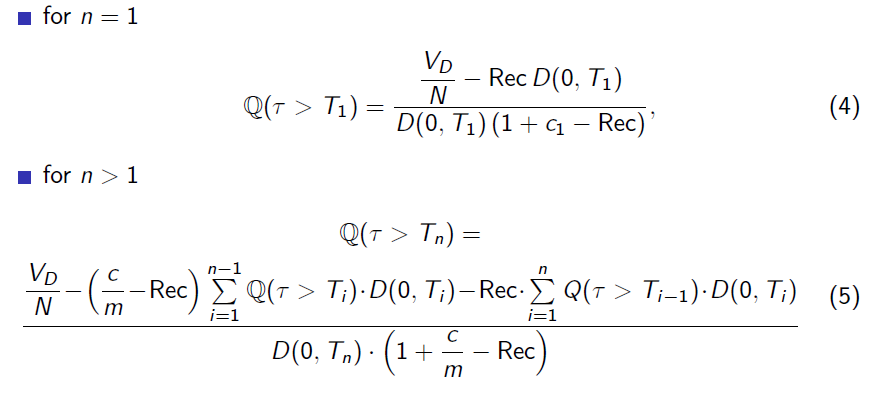

In [98]:
#GOOOOD
(0.96-((math.exp(-0.02*0.5)*(Rec*(1-Q)+0.025*Q))+(math.exp(-0.03)*Rec*Q)))/(math.exp(-0.03)*(1.025-Rec))

0.9046883321599666

In [83]:
#sum1
math.exp(-0.02*0.5)*(Rec*(1-Q)+0.025*Q)

0.06094994289018318

In [54]:
# Sum2
math.exp(-0.03)*Rec*Q

0.35033083761101147

In [66]:
bonds

{0.5: {'c': 0.04, 'p': 0.95, 'd': 0.9900498337491681},
 1: {'c': 0.05, 'p': 0.96, 'd': 0.9704455335485082}}

In [79]:
list(bonds)[1-1]

0.5

In [88]:
import numpy as np
np.zeros(2)[1]

0.0

In [112]:
sums = np.zeros(2)
for i,x in enumerate(bonds):
    if i == 0:
        pass
    else:
        sums[0] += bonds[list(bonds)[i-1]]['d']*\
        (Rec*(1-bonds[list(bonds)[i-1]]['Q'])+\
         (bonds[x]['c']/m)*bonds[list(bonds)[i-1]]['Q'])
        sums[1] += Rec*bonds[x]['d']*bonds[list(bonds)[i-1]]['Q']
(bonds[list(bonds)[-1]]['p']-sum(sums))/(bonds[list(bonds)[-1]]['d']*((1+((bonds[list(bonds)[-1]]['c']/m))-Rec)))

0.9046884374385575

In [107]:
bonds[list(bonds)[-1]]['p']

0.96

In [106]:
bonds[list(bonds)[-1]]

{'c': 0.05, 'p': 0.96, 'd': 0.9704455335485082}

In [113]:
test = [1.2,1.4,1.6,1.8]

In [123]:
np.where(np.array(test) == 1.6)[0][0]

2

In [136]:
bonds = {
    0.5: {'c':0.04, 'p':0.95, 'd':discount(0.02, t=0.5)},
    1: {'c':0.05, 'p':0.96, 'd':discount(0.03, t=1)}
}
def implied_survival_probs(bonds, N=100, Rec=0.4, m=2, T=list(bonds)[-1]):
    for i,x in enumerate(bonds):
        if i == 0:
            bonds[x]['Q'] = ((bonds[x]['p']/bonds[x]['d'])-Rec)/(1+bonds[x]['c']/m-Rec)
        else:
            sums = np.zeros(2)
            sums[0] += bonds[list(bonds)[i-1]]['d']*\
            (Rec*(1-bonds[list(bonds)[i-1]]['Q'])+\
             (bonds[x]['c']/m)*bonds[list(bonds)[i-1]]['Q'])
            sums[1] += Rec*bonds[x]['d']*bonds[list(bonds)[i-1]]['Q']
            bonds[x]['Q'] = (bonds[list(bonds)[-1]]['p']-sum(sums))/(bonds[list(bonds)[-1]]['d']*((1+((bonds[list(bonds)[-1]]['c']/m))-Rec)))
    return bonds[T]

implied_survival_probs(bonds) 